In [3]:
from __future__ import division
from dbhelper import get_crossings, pd_query
from modelhelper import cvfolds, rf_basic
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.grid_search import GridSearchCV

In [5]:
query = '''
        select 
            c.date,
            waittime,
            year,
            month,
            dayofmonth,
            week,
            dayofweek,
            EXTRACT(MINUTE FROM time - '00:00:00'::time) + 60 * EXTRACT(HOUR FROM time - '00:00:00'::time) minofday
        from crossingdata c
        join datefeatures d on c.date = d.date
        where
            valid=1
            and waittime is not null
            and crossing_id = %s
        order by c.date
        '''

df = pd_query(query, (1))

In [6]:
cv = cvfolds(df)

### Run a single test for last 3 years

In [5]:
model = RandomForestRegressor(n_jobs=-1, n_estimators=100)

In [6]:
X = df.copy()
y = X.pop('waittime')
X = X.drop('date', axis=1)

In [7]:
X.head()

,year,month,dayofmonth,week,dayofweek,minofday
0,2007,1,1,1,0,0
1,2007,1,1,1,0,5
2,2007,1,1,1,0,10
3,2007,1,1,1,0,15
4,2007,1,1,1,0,20


In [8]:
X_train = np.array(X)[cv[-1][0]]
y_train = np.array(y)[cv[-1][0]]
X_test = np.array(X)[cv[-1][1]]
y_test = np.array(y)[cv[-1][1]]

In [9]:
model.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=-1, oob_score=False, random_state=None,
           verbose=0, warm_start=False)

In [10]:
model.score(X_test, y_test)

-0.12240512762811173

In [11]:
yhat = model.predict(X_test)

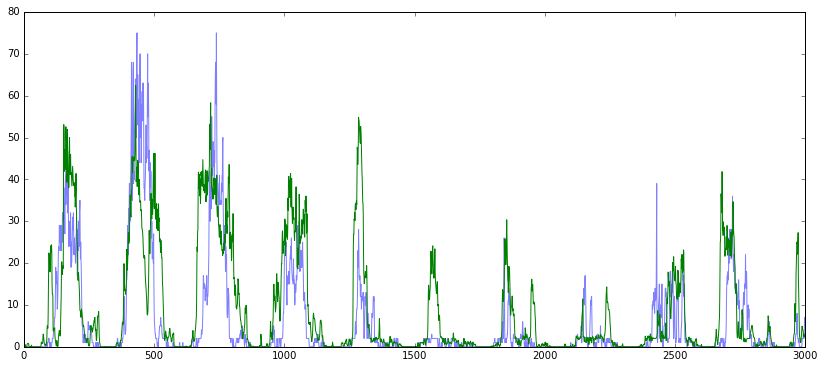

In [12]:
plt.figure(figsize=(14,6))
plt.plot(y_test[:3000], color='b', alpha=.5)
plt.plot(yhat[:3000], color='g');

Negative R^2 is poor, but at least for this restricted data set, the daily seasonality is evident.

Time to run with all data

In [13]:
model = RandomForestRegressor(n_jobs=-1)
params = {'n_estimators': [50]}
grid = GridSearchCV(model, params, cv=cv[:-1], n_jobs=-1)   # last cv set (2015) is holdout set

In [14]:
X = df.copy()
y = X.pop('waittime')
X = X.drop('date', axis=1)

In [15]:
grid.fit(X, y)

GridSearchCV(cv=[([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, ...8, 735839, 735840, 735841, 735842, 735843, 735844, 735845, 735846, 735847, 735848, 735849, 735850])],
       error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=-1, oob_score=False, random_state=None,
           verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'n_estimators': [50]}, pre_dispatch='2*n_jobs',
       refit=True, scoring=None, verbose=0)

In [16]:
grid.best_score_

0.093626006601625469

R^2 is worse.  Unexpected.

In [19]:
X_test = np.array(X)[cv[-1][1]]
y_test = np.array(y)[cv[-1][1]]

In [20]:
y_hat = grid.predict(X_test)

In [21]:
grid.score(X_test, y_test)

0.99314431511193224

In [22]:
df_predict = df[df.date >= '1/1/15'].copy()

In [23]:
df_predict['prediction'] = y_hat

In [24]:
df_predict.set_index('date', inplace=True)

In [25]:
def plot_waittimes(df, field, start, end):
    df[((df.index >= start) & (df.index < end))][['waittime', field]].plot(figsize=(14,6));

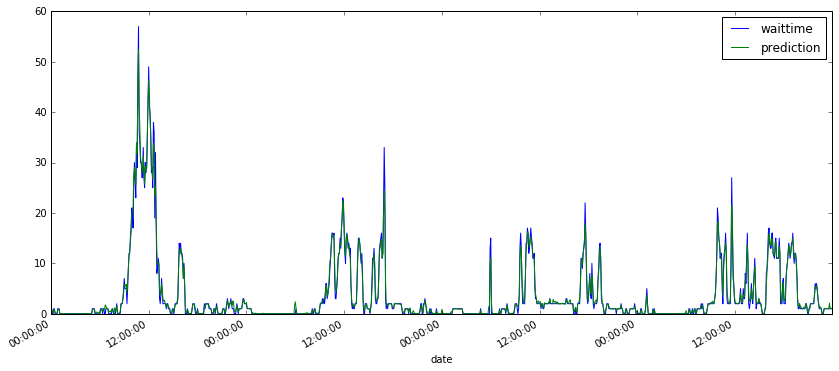

In [26]:
plot_waittimes(df_predict, 'prediction', '6/1/15', '6/5/15')

### Clearly 2015 data leaked into model

In [27]:
X_test = np.array(X)[cv[-1][1]]
y_test = np.array(y)[cv[-1][1]]
X_train = np.delete(np.array(X), cv[-1][1], 0)
y_train = np.delete(np.array(y), cv[-1][1], 0)

In [28]:
print X.shape
print X_test.shape
print X_train.shape

(829171, 6)
(93320, 6)
(735851, 6)


In [29]:
model = RandomForestRegressor(n_jobs=-1)
params = {'n_estimators': [50]}
grid = GridSearchCV(model, params, cv=cv[:-1], n_jobs=-1)   # last cv set (2015) is holdout set

In [30]:
grid.fit(X_train, y_train)
grid.best_score_

0.096903572533658403

In [31]:
y_hat = grid.predict(X_test)
grid.score(X_test, y_test)

-0.11298177367607809

In [32]:
df_predict = df[df.date >= '1/1/15'].copy()
df_predict.set_index('date', inplace=True)

In [33]:
df_predict['prediction'] = y_hat

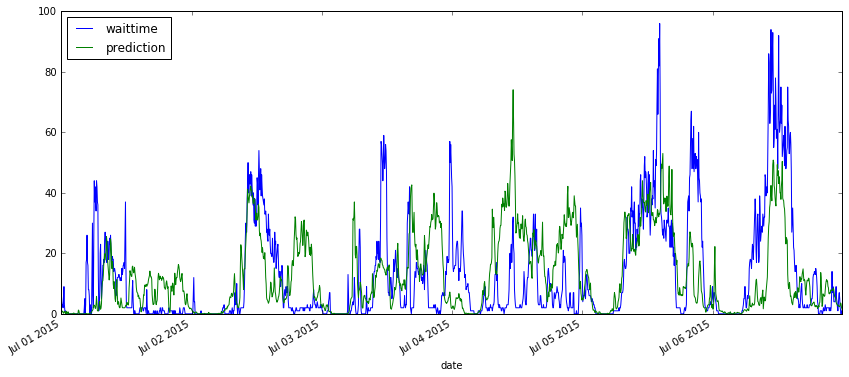

In [34]:
plot_waittimes(df_predict, 'prediction', '7/1/15', '7/7/15')

## Looks like overfitting
Compare against a simple average from previous year by day of week

In [35]:
summ2014 = df[df.year==2014].groupby(['dayofweek', 'minofday']).waittime.mean()

In [36]:
summ2014 = pd.DataFrame(summ2014)
summ2014.columns = ['wt_2014']
summ2014 = summ2014.reset_index()

In [37]:
df_predict.head()

,waittime,year,month,dayofmonth,week,dayofweek,minofday,prediction
date,,,,,,,,
2015-01-01 00:00:00,0,2015,1,1,1,3,0,0.02
2015-01-01 00:05:00,0,2015,1,1,1,3,5,0.02
2015-01-01 00:10:00,0,2015,1,1,1,3,10,0.08
2015-01-01 00:15:00,0,2015,1,1,1,3,15,0.02
2015-01-01 00:20:00,0,2015,1,1,1,3,20,0.06


In [38]:
dow = df_predict.reset_index().merge(summ2014, on=['dayofweek', 'minofday']).set_index('date')

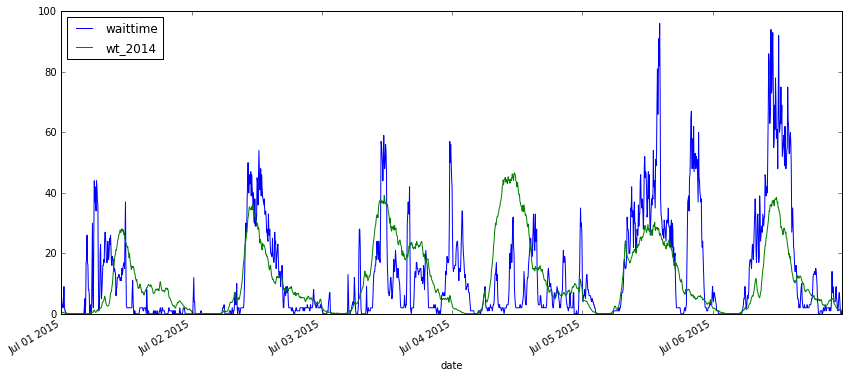

In [61]:
plot_waittimes(dow, 'wt_2014', '7/1/15', '7/7/15')

In [40]:
from sklearn.metrics import r2_score

print r2_score(dow.waittime, dow.wt_2014)
print r2_score(dow.waittime, dow.prediction)

0.143442299388
-0.112981773676


In [53]:
dow.describe().T

,count,mean,std,min,25%,50%,75%,max
waittime,93320,6.363405,11.186998,0,0.000000,2.00,7.000000,101.000000
year,93320,2015.000000,0.000000,2015,2015.000000,2015.00,2015.000000,2015.000000
month,93320,6.029372,3.136788,1,3.000000,6.00,9.000000,11.000000
dayofmonth,93320,15.523703,8.709490,1,8.000000,16.00,23.000000,31.000000
week,93320,24.805272,13.673577,1,13.000000,25.00,37.000000,48.000000
dayofweek,93320,3.020982,1.990679,0,1.000000,3.00,5.000000,6.000000
minofday,93320,718.942617,415.442668,0,360.000000,720.00,1080.000000,1435.000000
prediction,93320,10.717619,13.689776,0,0.660000,4.32,16.640000,92.040000
wt_2014,93320,10.566356,11.272841,0,1.519231,6.25,17.288462,46.634615


## Random Forest is worse than average by day of week
A model with just day of week and min of day should give similar result as 2014 average

In [41]:
df_dow = df.copy()
df_dow = df_dow.drop(['year', 'month', 'dayofmonth', 'week'], axis=1)

In [42]:
def rf_basic(df, cv, n_estimators=30):
    '''
    Run a basic 
    IN
        df: full dataframe of time series
            assumes date column will not be used as feature
            assumes waittime as label
        cv: cv folds
        n_estimators: Random Forest config
    OUT
        dataframe filtered for last cv fold, including prediction
    '''
    X = df.copy()
    y = X.pop('waittime')
    X = X.drop('date', axis=1)

    # Set last fold as test set
    X_test = np.array(X)[cv[-1][1]]
    y_test = np.array(y)[cv[-1][1]]
    # Remove last fold from training set
    X_train = np.delete(np.array(X), cv[-1][1], 0)
    y_train = np.delete(np.array(y), cv[-1][1], 0)

    # Prepare model`
    model = RandomForestRegressor(n_jobs=-1)
    params = {'n_estimators': [n_estimators]}
    grid = GridSearchCV(model, params, cv=cv[:-1], n_jobs=-1)
    grid.fit(X_train, y_train)
    
    # Filter dataframe to last cv period
    # Combine prediction with original dataframe 
    last_df = df.iloc[cv[-1][1][0]:cv[-1][1][-1] + 1]
    # Add prediction
    last_df['prediction'] = grid.predict(X_test)
    return last_df
    
dftest = rf_basic(df_dow, cv)

/Users/jng/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [58]:
print r2_score(dftest.waittime, dftest.prediction)
print r2_score(dow.wt_2014, dftest.prediction)

-0.375925858878
-1.63350339749


## Yikes, R^2 getting worse

In [50]:
df.head()

,date,waittime,year,month,dayofmonth,week,dayofweek,minofday
0,2007-01-01 00:00:00,0,2007,1,1,1,0,0
1,2007-01-01 00:05:00,0,2007,1,1,1,0,5
2,2007-01-01 00:10:00,0,2007,1,1,1,0,10
3,2007-01-01 00:15:00,0,2007,1,1,1,0,15
4,2007-01-01 00:20:00,0,2007,1,1,1,0,20


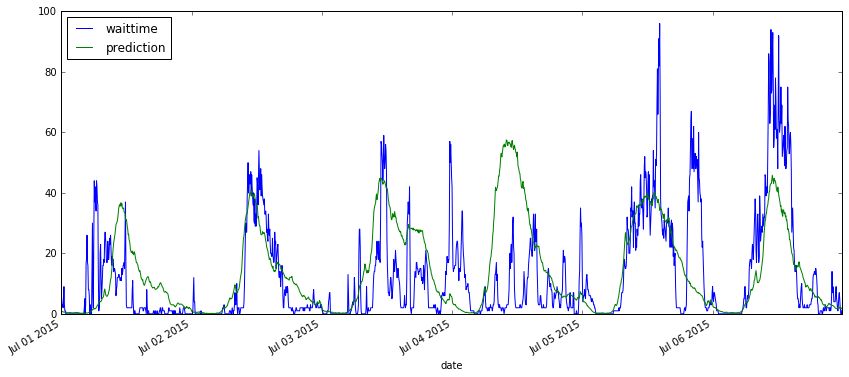

In [62]:
plot_waittimes(dftest.set_index('date'), 'prediction', '7/1/15', '7/7/15')

In [49]:
dftest.describe().T

,count,mean,std,min,25%,50%,75%,max
waittime,93320,6.363405,11.186998,0.000000,0.00000,2.000000,7.000000,101.00000
dayofweek,93320,3.020982,1.990679,0.000000,1.00000,3.000000,5.000000,6.00000
minofday,93320,718.942617,415.442668,0.000000,360.00000,720.000000,1080.000000,1435.00000
prediction,93320,13.400741,14.133666,0.067346,2.12484,7.377431,22.815051,57.47593


## Next steps
* Is volume more predictable?  Can we then predict volume, then predict wait time from predicted volume?
* Is prediction better with more years of trained data, e.g. 3 years instead of 2 years?
* Does smoothing improve the prediction?